# **Search faces**

# Установка библиотек

In [1]:
!pip install -U insightface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 6.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 35.9 MB/s eta 0:00:00
  Created wheel for insightface: filename=insightface-0.7.3-cp310-cp310-linux_x86_64.whl size=1055334 sha256=5d900454459819f1df9db719d64ce3457e84efd8c6fc40613bbc7b59ab50d316
  Stored in directory: /root/.cache/pip/wheels/e3/d0/80/e3773fb8b6d1cca87ea1d33d9b1f20a223a6493c896da249b5
Successfully built insightface


In [2]:
!pip install onnx

In [3]:
#!pip install onnxruntime-gpu
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.9 MB/s eta 0:00:00


In [4]:
!pip install PyMuPDF

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 74.9 MB/s eta 0:00:00


In [5]:
import insightface
print(insightface.__version__)

0.7.3


Начиная с версии библиотеки 0.2.0, в качестве бэкенда для вычислений используется не MXNet, а onnxruntime. Данная библиотека (нейронная сеть) позволяет в качестве инференса использовать CPU или GPU.

# Импорт библиотек, запуск модели

In [6]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from tqdm import tqdm
from datetime import datetime
import pandas as pd
import fitz # если раскомитить нужен pip install PyMuPDF библиотека для конвертации из pdf в img
import traceback
import onnxruntime as ort
from insightface.app import FaceAnalysis
from sklearn.neighbors import NearestNeighbors
from numpy.linalg import norm
from PIL import Image
from IPython.display import Image as imgplot

После импорта библиотек посмотрим, как можно извлечь изображение из pdf-файлов. Для этой задачи была выбрана библиотека fitz. Для корректной работы данной библиотеки необходимо установить пакет pymupdf.

In [7]:
app = FaceAnalysis(name="buffalo_l", providers=['CUDAExecutionProvider'])

download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:11<00:00, 25046.09KB/s]
/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5


In [8]:
import numpy
print(numpy.__version__)

1.25.2


In [9]:
app.prepare(ctx_id=0, det_size=(256,256))

set det-size: (256, 256)


In [10]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [11]:
!pwd

/content


In [12]:
!ls /content/gdrive/MyDrive/DataSearchFaces/

BradleyCooper.pdf  face  test_img.pdf


In [13]:
!ls /content/gdrive/MyDrive/DataSearchFaces/face/

AngelinaJolie1.pdf  BradleyCooper.jpg  BradPitt2.pdf   res.jpg
AngelinaJolie2.pdf  BradPitt1.pdf      icegif-852.gif  test_img.jpg


# Детекция лиц

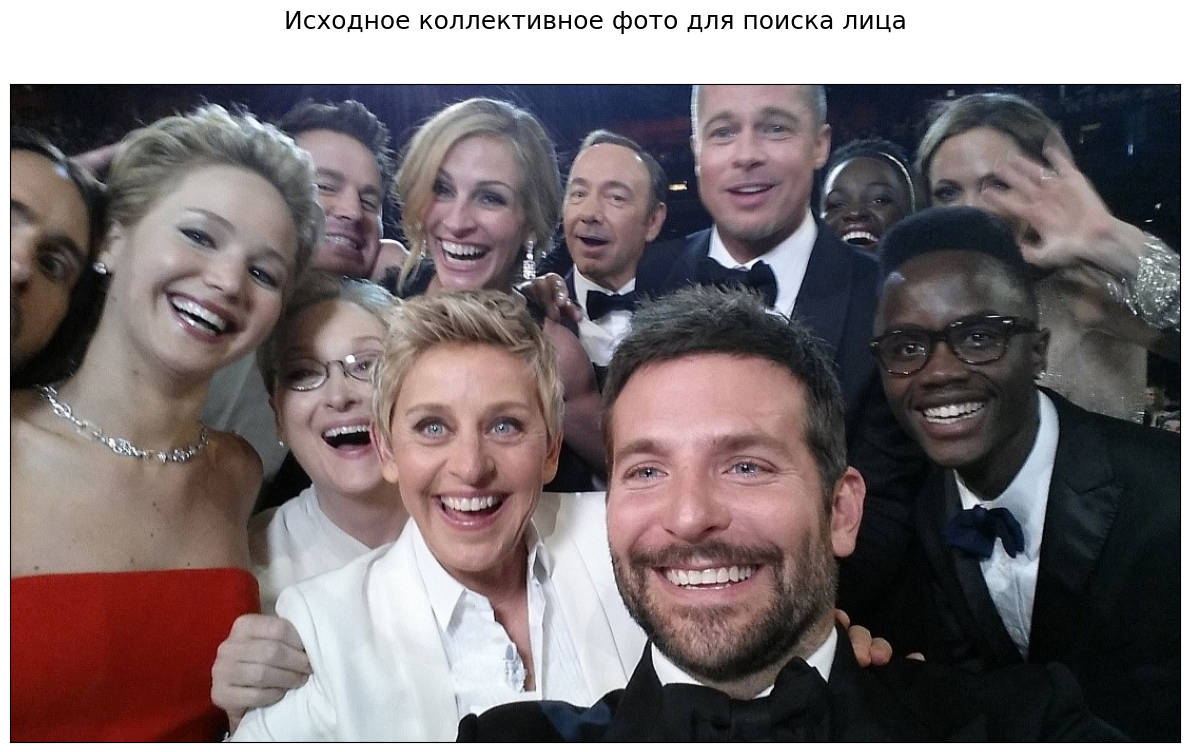

In [14]:
fig = plt.figure(figsize=(12, 8))
plt.suptitle("Исходное коллективное фото для поиска лица", fontsize=18)
plt.imshow(Image.open("/content/gdrive/MyDrive/DataSearchFaces/face/test_img.jpg"))
# для компактности удаляем оси и прижимаем изображения друг к другу
plt.xticks([])
plt.yticks([])
plt.tight_layout()

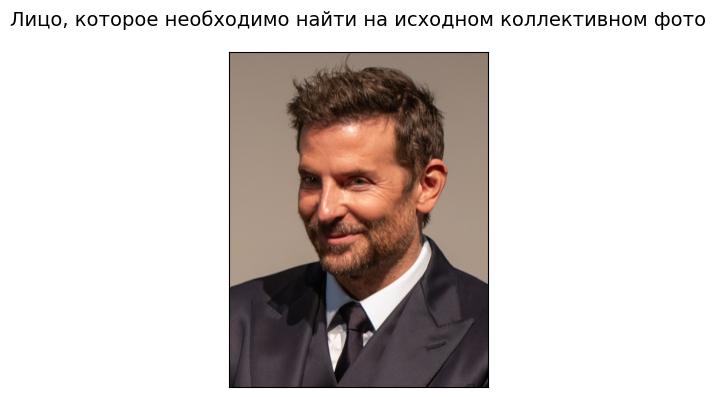

In [15]:
fig = plt.figure(figsize=(6, 4))
plt.suptitle("Лицо, которое необходимо найти на исходном коллективном фото", fontsize=14)
plt.imshow(Image.open("/content/gdrive/MyDrive/DataSearchFaces/face/BradleyCooper.jpg"))
# для компактности удаляем оси и прижимаем изображения друг к другу
plt.xticks([])
plt.yticks([])
plt.tight_layout()

In [16]:
class FaceWorker:

    def __init__(self):
        self.app = FaceAnalysis(name="buffalo_l", providers=['CUDAExecutionProvider'])
        self.app.prepare(ctx_id=0, det_size=(256,256))
        self.knn = NearestNeighbors(metric='cosine', algorithm='brute')

    def extract_faces_from_pdf(self,files_paths, result_images_directory='/content'):
        errors_count = 0
        try:
            with open('completed_files.csv','a+') as file:
                for file_path in tqdm(files_paths):
                    file_name = Path(file_path).stem
                    doc = fitz.open(file_path)
                    for i in range(len(doc)):
                        for img in doc.get_page_images(i):
                            xref = img[0]
                            pix = fitz.Pixmap(doc, xref)
                            if pix.n > 4:
                                pix = fitz.Pixmap(fitz.csRGB, pix)
                            img = np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.height, pix.width, pix.n)
                            try:
                                img = np.ascontiguousarray(img[...,[2,1,0]])
                            except IndexError:
                                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                                img = np.ascontiguousarray(img[...,[2,1,0]])
                            faces = self.app.get(img)
                            if len(faces)>0:
                                for j,face in enumerate(faces):
                                    try:
                                        bbox = face.bbox
                                        x1,y1,x2,y2 = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])
                                        crop_img = img[ y1:y2,x1:x2]
                                        face_directory  = os.path.join(result_images_directory, f'{file_name}_face_{j}.png')
                                        cv2.imwrite(face_directory, crop_img)
                                    except cv2.error as error:
                                        errors_count +=1
                                        continue
                    end_time = datetime.now().strftime('%d-%m-%Y %H:%M')
                    file.write(f'{file_path}|{end_time}\n')
        except:
            error = traceback.format_exc()
            print(f'При попытке поиска лиц в pdf-файлах произошла ошибка:\n{error}\nПоследний обработанный файл записан в completed_files.csv\n')
        finally:
            print(f'Ошибок записи cv2.error - {errors_count}')

    def face_vectorizer(self, face_path):
        try:
            image = cv2.imread(face_path)
            faces = self.app.get(image)
            if len(faces)>0:
                return faces[0].embedding
        except:
            error = traceback.format_exc()
            print(error)

    def search_similar_faces(self, vectors_dict, neighbors_count=20, tolerance=0.80):
        self.knn.fit(vectors_dict['images_vectors'])
        similar_images = []
        for vector in tqdm(vectors_dict['images_vectors']):
            dist, indicies = self.knn.kneighbors([vector], n_neighbors=neighbors_count)
            dist, indicies = list(dist[0]), list(indicies[0])
            l = [(vectors_dict['images_paths'][indicies[i]], dist[i]) for i in range(len(indicies)) if dist[i]<tolerance]
            similar_images.append(l)
        return similar_images

Применю полученный код для поиска лиц в pdf‑файлах и их преобразования в векторное представление:

In [17]:
fw = FaceWorker()
pdfs = glob.glob('/content/gdrive/MyDrive/DataSearchFaces/*.pdf')
print(f'Количество pdf-файлов для обработки - {len(pdfs)}')
fw.extract_faces_from_pdf(pdfs)
search_faces = glob.glob('/content/*.png')
vectors_dict = {
    'images_paths':[],
    'images_vectors':[]
}
for search_face in tqdm(search_faces):
    vector = fw.face_vectorizer(search_face)
    if vector is not None:
        vectors_dict['images_paths'].append(search_face)
        vectors_dict['images_vectors'].append(vector)
print('Лица преобразованы в вектора.')

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (256, 256)
Количество p

  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4
100%|██████████| 2/2 [00:08<00:00,  4.45s/it]


Ошибок записи cv2.error - 1


100%|██████████| 11/11 [00:08<00:00,  1.26it/s]

Лица преобразованы в вектора.


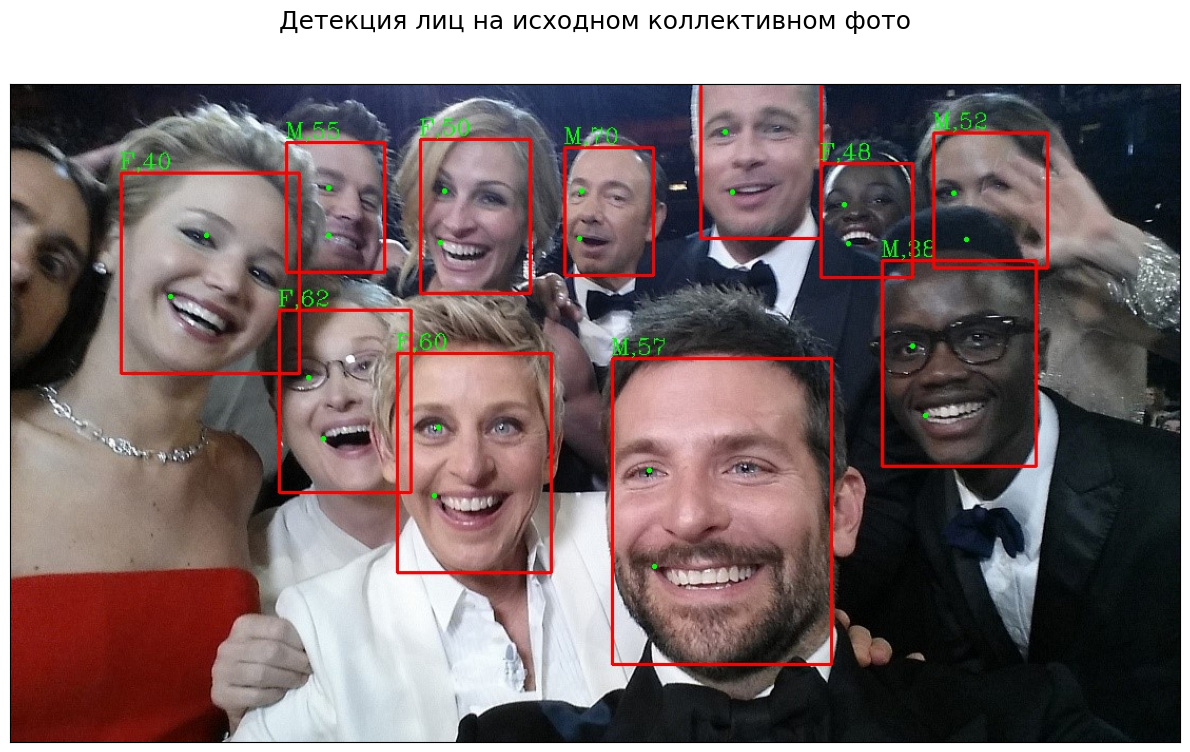

In [18]:
fig = plt.figure(figsize=(12, 8))
plt.suptitle("Детекция лиц на исходном коллективном фото", fontsize=18)
plt.imshow(Image.open("/content/gdrive/MyDrive/DataSearchFaces/face/res.jpg"))
# для компактности удаляем оси и прижимаем изображения друг к другу
plt.xticks([])
plt.yticks([])
plt.tight_layout()

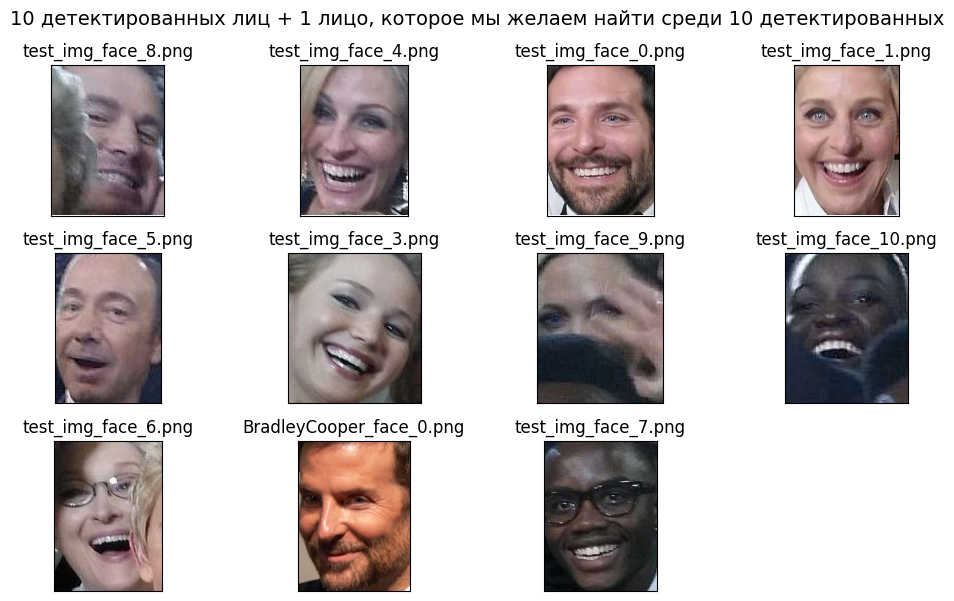

In [23]:
# выводим 11 детектированных лиц + 1 лицо, которое мы желаем найти среди 11 детектированных
fig = plt.figure(figsize=(10, 8))
plt.suptitle("10 детектированных лиц + 1 лицо, которое мы желаем найти среди 10 детектированных", fontsize=14)
for i in range(len(search_faces)):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(Image.open(search_faces[i]))
    label_face = search_faces[i][9:]
    plt.title(label_face)
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

In [20]:
similar_faces = fw.search_similar_faces(vectors_dict, 2, 0.7)
print('Сформирован список схожих лиц.')
all_similar_images = []
for cluster in similar_faces:
    similar_images = [element[0] for element in cluster]
    all_similar_images.append(similar_images)
filtered_similar_images = []
for i,element in enumerate(all_similar_images):
    if set(element) not in filtered_similar_images:
        filtered_similar_images.append(set(element))
print('Отфильтрованы все возможные комбинации одних и тех же изображений.')

100%|██████████| 11/11 [00:00<00:00, 756.83it/s]

Сформирован список схожих лиц.
Отфильтрованы все возможные комбинации одних и тех же изображений.


In [21]:
filtered_similar_images

[{'/content/test_img_face_8.png'},
 {'/content/test_img_face_4.png'},
 {'/content/BradleyCooper_face_0.png', '/content/test_img_face_0.png'},
 {'/content/test_img_face_1.png'},
 {'/content/test_img_face_5.png'},
 {'/content/test_img_face_3.png'},
 {'/content/test_img_face_9.png'},
 {'/content/test_img_face_10.png'},
 {'/content/test_img_face_6.png'},
 {'/content/test_img_face_7.png'}]

# Результат поиска схожих людей

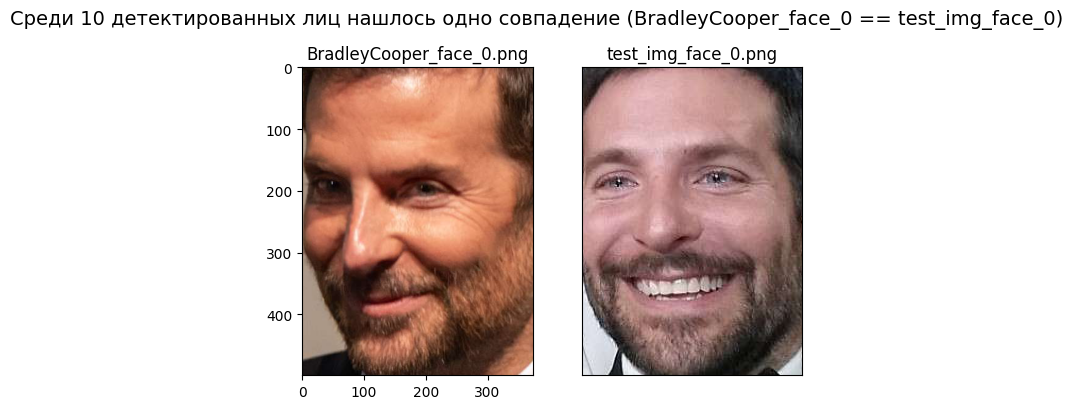

In [24]:
# выводим 11 детектированных лиц + 1 лицо, которое мы желаем найти среди 11 детектированных
fig = plt.figure(figsize=(6, 4))
plt.suptitle("Среди 10 детектированных лиц нашлось одно совпадение (BradleyCooper_face_0 == test_img_face_0)", fontsize=14)
fig.add_subplot(1, 2, 1)
plt.imshow(Image.open('/content/BradleyCooper_face_0.png'))
plt.title("BradleyCooper_face_0.png")
fig.add_subplot(1, 2, 2)
plt.imshow(Image.open('/content/test_img_face_0.png'))
plt.title("test_img_face_0.png")
# для компактности удаляем оси и прижимаем изображения друг к другу
plt.xticks([])
plt.yticks([])
plt.tight_layout()

# **The end**